# 빅데이터 분석 (6주차) 10월19일
> 드랍아웃, fastai를 이용한 학습, CPU vs GPU

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Big Data Analysis, 드랍아웃, fastai를 이용한 학습, CPU vs GPU, pseudocode]

------------------

드랍아웃: 노드에 들어가는 인풋을 임읠 0으로 만들어 학습이 되지 않게 만드는 것.
- 오버피팅 피하기

------------------------------

In [1]:
import torch 
import matplotlib.pyplot as plt 

In [3]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01

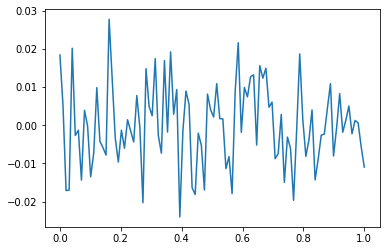

In [4]:
plt.plot(X,y)

### 네트워크 설정, 옵티마이저, 로스 

In [8]:
X.shape,y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [5]:
torch.manual_seed(1) # 초기가중치를 똑같이 , 위 plot을 맞춰보는 net설정해보기
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

### 모형학습 

In [9]:
for epoc in range(1000): 
    ## 1 
    yhat=net(X) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 

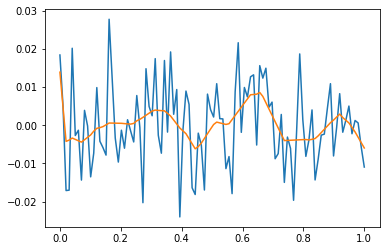

In [10]:
plt.plot(X,y) 
plt.plot(X,yhat.data)

- 학습시킨 yhat이 y를 따라가면 안 돼, 우리는 임의로 뽑은 것이니까 나오려면 , 직선이 나와야지
- 전형적인 overfitting case
- 또 trend가 있는게 맞는 건지, 0이어야만 하는건지 확실히 알 수 없다
- 그래서 train/validation 나누어서 해보고 그 train을 통해 얻은 선이 validation에 맞나? 맞는 거 빼고 다 오버피팅~

### train / validation 

In [11]:
X1=X[:80]
y1=y[:80]
X2=X[80:]
y2=y[80:] 

In [12]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [13]:
for epoc in range(1000): 
    ## 1 
    y1hat=net(X1) 
    ## 2 
    loss=loss_fn(y1hat,y1) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step() 
    net.zero_grad() 

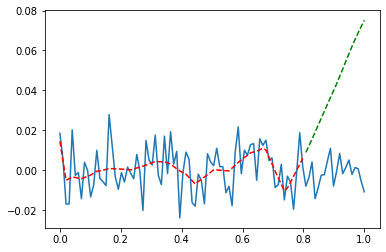

In [14]:
plt.plot(X,y)
plt.plot(X1,net(X1).data,'--r') 
plt.plot(X2,net(X2).data,'--g') 

- 보이는 패턴만 따라가서 loss 줄이려고 하니까
- 위와 같은 오버피팅이 나옴

### 드랍아웃 

In [16]:
X1=X[:80]
y1=y[:80]
X2=X[80:]
y2=y[80:] 

In [22]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Dropout(0.8), ############################ 다음에 통과한 노드의 80%가 0이 되어 y 출력
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [23]:
for epoc in range(1000): 
    ## 1 
    y1hat=net(X1) 
    ## 2 
    loss=loss_fn(y1hat,y1) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step() 
    net.zero_grad() 

In [38]:
# list(net.parameters())

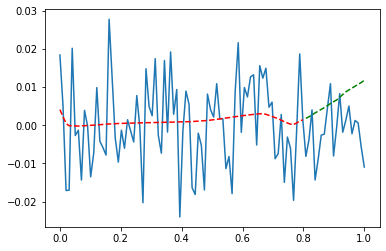

In [36]:
net.eval() ## 네트워크를 평가모드로 전환
# 학습할 때는 0으로 만들고 평가할 때는 0으로 만들 필요가 없지
plt.plot(X,y)
plt.plot(X1,net(X1).data,'--r') 
plt.plot(X2,net(X2).data,'--g') 

> warning: 512개 노드들이 업데이트가 될때 잘 된 특정 노드 위주로 노드가 몰리게 된다. 이는 오버피팅을 불러 일으킬 수 있다.


- 학습할때는  **torch.nn.Dropout(0.8)** 놓고 평가할때는 지워야겠지
- 80개 train data만 봤을때 dropout한 게 잘 맞는지 아닌지는 관점의 차이일 수 있지만
- 20개 test data 봤을때 dropout한 게 잘 맞는다는 것을 알 수 있지

ref: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

- During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.
- This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons as described in the paper Improving neural networks by preventing co-adaptation of feature detectors .

### 학습과정 비교 (주의: 코드복잡함)  

`-` 데이터 생성

In [39]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1) 
y=torch.randn(100).reshape(100,1) 

`-` tr/val 분리

In [40]:
X_tr=X[:80]
y_tr=y[:80]
X_val=X[80:]
y_val=y[80:] 

`-` 네트워크, 옵티마이저, 손실함수 설정 

- 드랍아웃을 이용한 네트워트 (net2)와 그렇지 않은 네트워크 (net1) 
- 대응하는 옵티마이저 1,2 설정 
- 손실함수 

In [42]:
torch.manual_seed(1) 
net1=torch.nn.Sequential(
    torch.nn.Linear(1,512), 
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)) 
optimizer_net1 = torch.optim.Adam(net1.parameters()) 
net2=torch.nn.Sequential(
    torch.nn.Linear(1,512), 
    torch.nn.ReLU(),
    torch.nn.Dropout(0.8),
    torch.nn.Linear(512,1)) 
optimizer_net2 = torch.optim.Adam(net2.parameters())
loss_fn=torch.nn.MSELoss()

In [43]:
tr_loss_net1=[]  # 시뮬레이션 결과 저장할 공간을 만드는 과정
val_loss_net1=[]
tr_loss_net2=[] 
val_loss_net2=[] 

In [44]:
for epoc in range(1000): 
    ## 1 
    yhat_tr_net1 = net1(X_tr) 
    ## 2 
    loss_tr = loss_fn(yhat_tr_net1, y_tr) 
    ## 3 
    loss_tr.backward() 
    ## 4 
    optimizer_net1.step()
    net1.zero_grad() 
    ## 5 기록 
    ### tr 
    tr_loss_net1.append(loss_tr.item())
    
    ### val 
    yhat_val_net1 = net1(X_val) 
    loss_val = loss_fn(yhat_val_net1,y_val) 
    val_loss_net1.append(loss_val.item())

In [47]:
for epoc in range(1000): 
    ## 1 
    yhat_tr_net2 = net2(X_tr) 
    ## 2 
    loss_tr = loss_fn(yhat_tr_net2, y_tr) 
    ## 3 
    loss_tr.backward() 
    ## 4 
    optimizer_net2.step()
    net2.zero_grad() 
    ## 5 기록 
    ### tr 
    net2.eval()
    tr_loss_net2.append(loss_tr.item())
    ### val 
    yhat_val_net2 = net2(X_val) 
    loss_val = loss_fn(yhat_val_net2,y_val) 
    val_loss_net2.append(loss_val.item())
    net2.train() # training 모드로 변환

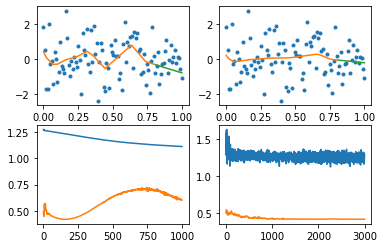

In [51]:
net2.eval() # 그림 그리기 위해 또 코드 추가
fig , ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
ax1.plot(X,y,'.');ax1.plot(X_tr,net1(X_tr).data); ax1.plot(X_val,net1(X_val).data); 
ax2.plot(X,y,'.');ax2.plot(X_tr,net2(X_tr).data); ax2.plot(X_val,net2(X_val).data); 
ax3.plot(tr_loss_net1);ax3.plot(val_loss_net1);
ax4.plot(tr_loss_net2);ax4.plot(val_loss_net2);

- ax3 내려가다(잘 적합) 올라간다(과적합)
- ax4 점점 내려감(잘 적합)

`-` 다 좋은데 코드를 짜는것이 너무 힘들다. 

- 생각해보니까 미니배치도 만들어야 함 + 미니배치를 나눈상태에서 GPU 메모리에 파라메터도 올려야함. 
- 조기종료(과적합 전 종료)와 같은 기능도 구현해야함 + 기타등등을 구현해야함. 
- 나중에는 학습률을 서로 다르게 돌려가며 결과도 기록해야함 $\to$ 그래야 좋은 학습률 선택가능 
- for문안에 step1~step4를 넣는것도 너무 반복작업임. 
- 등등.. 

`-` 위와 같은 것들의 특징: 머리로 상상하기는 쉽지만 실제 구현하는 것은 까다롭다. 

> note: pseudocode 의사코드:  In computer science, pseudocode is a plain language description of the steps in an algorithm or another system. Pseudocode often uses structural conventions of a normal programming language, but is intended for human reading rather than machine reading. It typically omits details that are essential for machine understanding of the algorithm, such as variable declarations and language-specific code. The programming language is augmented with natural language description details, where convenient, or with compact mathematical notation. The purpose of using pseudocode is that it is easier for people to understand than conventional programming language code, and that it is an efficient and environment-independent description of the key principles of an algorithm. It is commonly used in textbooks and scientific publications to document algorithms and in planning of software and other algorithms.

- ref: https://en.wikipedia.org/wiki/Pseudocode

`-` 사실 우리가 하고싶은것 

- **아키텍처를 설계**: 데이터를 보고 맞춰서 설계해야할 때가 많음 (우리가 해야한다) 
- 손실함수: 통계학과 교수님들이 연구하심 
- 옵티마이저: 산공교수님들이 연구하심 

`-` 교수님 생각 

- 기업의 욕심: real-data를 분석하는 딥러닝 아키텍처 설계 $\to$ 아키텍처별로 결과를 관찰 (편하게) $\Longrightarrow$ fastai + real data 
- 학생의 욕심: 그러면서도 모형이 돌아가는 원리는 아주 세밀하게 알고싶음 $\Longrightarrow$ pytorch + toy example (regression 등을 위주로) 
- 연구자의 욕심: 기존의 모형을 조금 변경해서 쓰고싶음 $\Longrightarrow$ (pytorch + fastai) + any data 

`-` **tensorflow + keras** vs **pytorch + fastai** 

### pytorch + fastai 

`-` 데이터셋을 만든다. 

In [52]:
X_tr=X[:80]
y_tr=y[:80]
X_val=X[80:]
y_val=y[80:] 

In [53]:
ds1=torch.utils.data.TensorDataset(X_tr,y_tr) 
ds2=torch.utils.data.TensorDataset(X_val,y_val) 

`-` 데이터로더를 만든다. 

- 여기까지 pytorch level

- 다음부터 fastai 

In [55]:
dl1 = torch.utils.data.DataLoader(ds1, batch_size=80) # 80개 다 쓰겠다~
dl2 = torch.utils.data.DataLoader(ds2, batch_size=20) 

`-` 데이터로더스를 만든다. 

In [56]:
from fastai.vision.all import * 

In [57]:
dls=DataLoaders(dl1,dl2) 

#### 드랍아웃 제외버전 

`-` 네트워크 설계 (드랍아웃 제외) 

In [58]:
torch.manual_seed(1) 
net_fastai = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=512),
    torch.nn.ReLU(),
    #torch.nn.Dropout(0.8),
    torch.nn.Linear(in_features=512, out_features=1)) 
#optimizer 
loss_fn=torch.nn.MSELoss() # torch에 있는 거 넣어줘도 된다

`-` 러너오브젝트 (for문 대신돌려주는 오브젝트) 

In [59]:
lrnr= Learner(dls,net_fastai,opt_func=Adam,loss_func=loss_fn) 

`-` 에폭만 설정하고 바로 학습

In [ ]:
#collapse-output
lrnr.fit(1000)

epoch,train_loss,valid_loss,time
0,1.277156,0.491314,00:00
1,1.277145,0.455286,00:00
2,1.275104,0.444275,00:00
3,1.274429,0.465787,00:00
4,1.273436,0.507203,00:00
5,1.272421,0.548102,00:00
6,1.271840,0.561292,00:00
7,1.271377,0.549409,00:00
8,1.270855,0.530416,00:00
9,1.270437,0.520700,00:00


`-` loss들도 에폭별로 기록되어 있음 

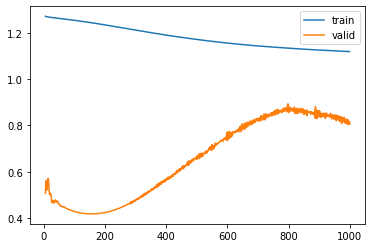

In [ ]:
lrnr.recorder.plot_loss()

`-` net_fastai에도 파라메터가 업데이트 되어있음 

In [ ]:
#
# list(net_fastai.parameters())

- 리스트를 확인해보면 net_fastai 의 파라메터가 알아서 GPU로 옮겨져서 학습됨. 

`-` 플랏 

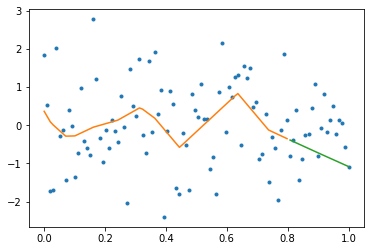

In [ ]:
net_fastai.to("cpu") #  net_fastai 의 파라메터가 알아서 GPU로 옮겨져서 학습되기 때문에 CPU로 옮기기 위해 필요한 옵션
plt.plot(X,y,'.')
plt.plot(X_tr,net_fastai(X_tr).data) 
plt.plot(X_val,net_fastai(X_val).data) 

#### 드랍아웃 추가버전 

`-` 네트워크 설계 (드랍아웃 추가) 

In [62]:
torch.manual_seed(1) 
net_fastai = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.8),
    torch.nn.Linear(in_features=512, out_features=1)) 
#optimizer 
loss_fn=torch.nn.MSELoss()

`-` 러너오브젝트 (for문 대신돌려주는 오브젝트) 

In [63]:
lrnr= Learner(dls,net_fastai,opt_func=Adam,loss_func=loss_fn) 

`-` 에폭만 설정하고 바로 학습

In [ ]:
#collapse-output
lrnr.fit(1000)

epoch,train_loss,valid_loss,time
0,1.585653,0.428918,00:00
1,1.552326,0.434847,00:00
2,1.568810,0.442775,00:00
3,1.543528,0.449585,00:00
4,1.562597,0.456666,00:00
5,1.523623,0.459943,00:00
6,1.506816,0.458130,00:00
7,1.510407,0.455353,00:00
8,1.532602,0.449054,00:00
9,1.528153,0.445443,00:00


`-` loss들도 에폭별로 기록되어 있음 

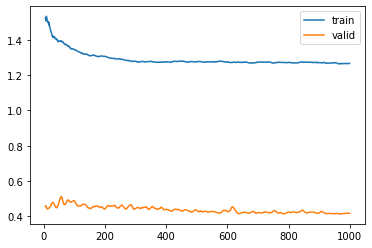

In [ ]:
lrnr.recorder.plot_loss()

`-` net_fastai에도 파라메터가 업데이트 되어있음 

In [ ]:
# list(net_fastai.parameters())

- 리스트를 확인해보면 net_fastai 의 파라메터가 알아서 GPU로 옮겨져서 학습됨. 

`-` 플랏 

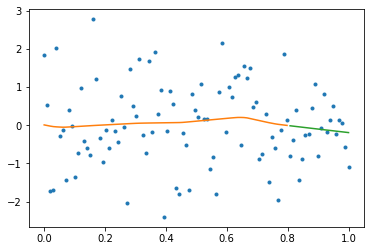

In [ ]:
net_fastai.to("cpu") 
plt.plot(X,y,'.')
plt.plot(X_tr,net_fastai(X_tr).data) 
plt.plot(X_val,net_fastai(X_val).data) 

### CPU vs GPU 시간비교

In [65]:
import time  # 시간 보는 함수

#### CPU (512) 

In [66]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01

In [67]:
torch.manual_seed(1) # 초기가중치를 똑같이 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [68]:
t1=time.time()
for epoc in range(1000): 
    ## 1 
    yhat=net(X) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 
t2=time.time()    

In [69]:
t2-t1

0.5504322052001953

#### GPU (512) 

In [70]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01

In [71]:
torch.manual_seed(1) # 초기가중치를 똑같이 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
net.to("cuda:0")
X=X.to("cuda:0")
y=y.to("cuda:0")
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [72]:
t1=time.time()
for epoc in range(1000): 
    ## 1 
    yhat=net(X) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 
t2=time.time()    

In [73]:
t2-t1

2.342357873916626

`-` ?? CPU가 더 빠르다!!

#### CPU (20480) 

In [74]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01

In [75]:
torch.manual_seed(1) # 초기가중치를 똑같이 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=20480), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=20480,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [76]:
t1=time.time()
for epoc in range(1000): 
    ## 1 
    yhat=net(X) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 
t2=time.time()    

In [77]:
t2-t1

3.8015544414520264

#### GPU (20480) 

In [78]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01

In [79]:
torch.manual_seed(1) # 초기가중치를 똑같이 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=20480), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=20480,out_features=1)) 
net.to("cuda:0")
X=X.to("cuda:0")
y=y.to("cuda:0")
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [80]:
t1=time.time()
for epoc in range(1000): 
    ## 1 
    yhat=net(X) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 
t2=time.time()    

In [81]:
t2-t1

2.3244359493255615

#### CPU (204800) 

In [82]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01

In [83]:
torch.manual_seed(1) # 초기가중치를 똑같이 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=204800), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=204800,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [84]:
t1=time.time()
for epoc in range(1000): 
    ## 1 
    yhat=net(X) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 
t2=time.time()    

In [85]:
t2-t1

62.91938018798828

#### GPU (204800) 

In [86]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01

In [87]:
torch.manual_seed(1) # 초기가중치를 똑같이 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=204800), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=204800,out_features=1)) 
net.to("cuda:0")
X=X.to("cuda:0")
y=y.to("cuda:0")
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [88]:
t1=time.time()
for epoc in range(1000): 
    ## 1 
    yhat=net(X) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 
t2=time.time()    

In [89]:
t2-t1

2.087972640991211

### 숙제 

`-` 현재 작업하고 있는 컴퓨터에서 아래코드를 실행후 시간을 출력하여 스샷제출 

#### CPU (512) 

In [90]:
torch.manual_seed(5) 
X=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01

In [91]:
torch.manual_seed(1) # 초기가중치를 똑같이 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizer= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

In [92]:
t1=time.time()
for epoc in range(1000): 
    ## 1 
    yhat=net(X) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad() 
t2=time.time()    

In [93]:
t2-t1

0.5490124225616455